<a href="https://colab.research.google.com/github/FelixSchmid/Reinforcement_Learning/blob/master/bandits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-armed bandits

In this notebook we are going to implement ETC and UCB.

Outline:
* Simulator writing
* ETC and experiments
* UCB and experiments

## Bulding a simulator for the bandit

In [0]:
from matplotlib import pyplot as plt
import numpy as np  # we can use this library for working with matrices

In [0]:
class Bandit:
    def __init__(self, k, means, rounds):
        # we assume Gaussian distributions with sigma=1
        self.k = k  # number of arms
        self.means = means
        self.rounds = rounds  # number of available rounds
        
        # ----- chose the optimal reward -----
        self.optimal_reward = max(self.means)
        self.counter = 0
        # gather the empirical regret so far
        self.empirical_regret = 0
        self.emp_regrets = []
        # gather the expected regret so far
        self.expected_regret = 0
        self.exp_regrets = []
    
    def play_arm(self, arm):
        # ----- sample the appropriate reward -----
        mu=self.means[arm]
        reward=np.random.normal(mu)
        self.empirical_regret+=self.optimal_reward-reward
        self.expected_regret += self.optimal_reward-mu
        self.counter += 1
        self.emp_regrets.append(self.empirical_regret)
        self.exp_regrets.append(self.expected_regret)
        # ----- calculate the regret so far and save it -----
        
        
        return reward
    
    def finished(self):
        # ----- return if there is no more round remained -----
        return self.counter >= self.rounds
    
    def plot_regret(self):
        plt.plot(list(range(self.counter)), self.emp_regrets, 'b+', list(range(self.counter)), self.exp_regrets, 'ro')
        plt.xlabel("iteration")
        plt.ylabel("regret")
        plt.show()

## ETC algorithm

In [0]:
class ETCsolver:
    def __init__(self, k, m, bandit):
        self.k = k  # number of arms
        self.m = m  # number of exploration rounds for each arm
        self.bandit = bandit
        
        # ----- create a cache storing the number of trials and the average rewards -----
        # for each action
        self.cache = np.zeros((k, 2))
    
    def _exploration_phase(self):
        counter = 0
        while counter < self.k * self.m:
            arm=counter % self.k
            reward=self.bandit.play_arm(arm)
            self.cache[arm,0]+=1
            self.cache[arm,1]+=reward
            counter += 1
            # ----- implement the exploration part -----
            # play the bandit and update cache
    
    def _choose_best_action(self):
        # ----- we calculate the average reward of each arm -----
        scores=self.cache[:,1]/self.cache[:,0]
        # return the best arm
        return np.argmax(scores)
        
        return 
    
    def run(self):
        self._exploration_phase()
        # after exploration we choose the best action
        optimal_arm = self._choose_best_action()
        # ----- play until finished -----
        while self.bandit.finished() == False:
            self.bandit.play_arm(optimal_arm)
    
    def get_regret(self):
        return self.bandit.regrets
    
    def best_action(self):
        return self._choose_best_action() + 1

In [0]:
def experiment_etc(k, mu, m, rounds):
    bandit = Bandit(k, mu, rounds)
    etc = ETCsolver(k, m, bandit)

    etc.run()
    etc.bandit.plot_regret()
    print("Optimal action: {}".format(etc.best_action()))

## UCB algorithm

In [0]:
class UCBsolver:
    def __init__(self, k, delta, bandit):
        self.k = k  # number of actions
        self.delta = delta  # error probability
        self.bandit = bandit

        self.cache = np.zeros((k, 2))  # stores the number and rewards so far
        self.actions = []
    
    def _init_phase(self):
        # at the very beginning each arm is equally good
        # unexplored arms are always the best
        # ----- pick each arm once to initialize the cache -----
        # we want to avoid division by zero
        for arm in range(self.k):
            # TODO
            self.cache[arm,0]+=1
            reward=self.bandit.play_arm(arm)
            self.cache[arm,1]=reward
            self.actions.append(arm)

    def _choose_best_action(self):
        # this implements the score for ucb
        # ----- first is the average reward term -----
        avg_reward = self.cache[:,1]/self.cache[:,0]
        # ----- second is the exploration term -----
        expl_term = np.sqrt((2*np.log(1/self.delta))/self.cache[:,0])

        ucb_score = avg_reward + expl_term
        
        return np.argmax(ucb_score)

    def run(self):
        self._init_phase()
        # ----- while not finished -----
        while self.bandit.finished() == False:
            # ----- chooe optimal arm -----
            optimal_arm = self._choose_best_action()
            # ----- storing the actions so far -----
            self.actions.append(optimal_arm)           
            # ----- playing the chosen arm -----
            reward=self.bandit.play_arm(optimal_arm)
            # ----- update cache -----
            self.cache[optimal_arm,0]+=1
            self.cache[optimal_arm,1]+=reward
    
    def plot_actions(self):
        plt.plot(list(range(len(self.actions))), self.actions, 'r+')
        plt.xlabel("iteration")
        plt.ylabel("chosen action")
        plt.show()

In [0]:
def experiment_ucb(k, mu, delta, rounds):
    bandit = Bandit(k, mu, rounds)
    ucb = UCBsolver(k, delta, bandit)

    ucb.run()
    ucb.bandit.plot_regret()
    ucb.plot_actions()

## Experiments

### ETC use-cases

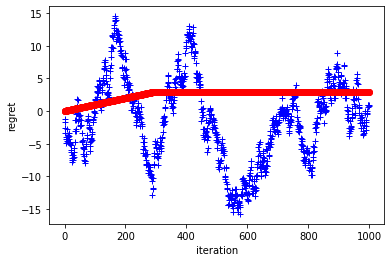

Optimal action: 2


In [0]:
experiment_etc(k=2, mu=[0.2, 0.22], m=150, rounds=1000)

The smaller the difference between mu, the longer the exploration phase (higher m) needs to be to confidently find the best arm. As the algorithm after exploration chooses the action with the best historical average reward and reward is given by a random normal distribution, there is no definite answer on how many number of rounds are required to find the best solution. For this run, the algorithm found the best action (2) after 300 iterations. If we were unlucky and draw rather high rewards from action 1 and or rather low rewards from action 2, 300 iterations might would not be sufficient. Thanks to the law of big numbers, the mean of drawn reward from each arm should get more stable with more rounds. That means the more rounds we attribute to the exploration phase, the better the chances to find the best arm.

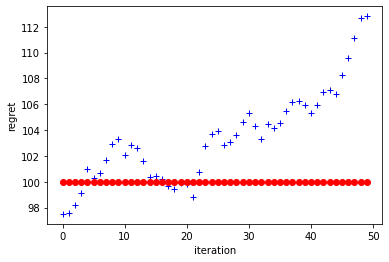

Optimal action: 2


In [0]:
# Try it with two arms and big difference between the mean values
# What are the required number of rounds to find the best action?
experiment_etc(k=2, mu=[0, 100], m=1, rounds=50)


Here, m=1 is enough as the mus lie far arpart and standard deviation is only 1, meaning at the first exploration step, the best arm is found as the distributions of the arms do not overlap. Except, of course, we draw an extreme outlier in the beginning, which is highly unlikely with the defined set up here.

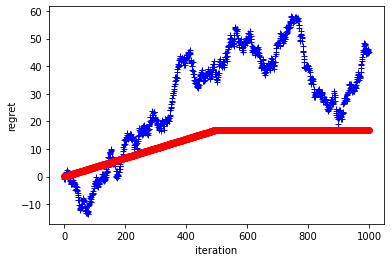

Optimal action: 5


In [0]:
experiment_etc(k=5, mu=[0.2, 0.22, 0.24, 0.25, 0.27], m=100, rounds=1000)


Same logic as before. Additionally, the exploration phase needs to be prolonged as the number of arms increases. With the same m, the exploration phase (overall amount of rounds) is automatically longer. Exploration phase = m*k

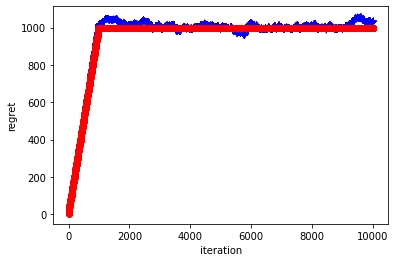

Optimal action: 50


In [0]:
experiment_etc(k=50, mu=np.linspace(0,2,50), m=20, rounds=10000)


The same arguments as mentioned already apply.

### UCB use-cases

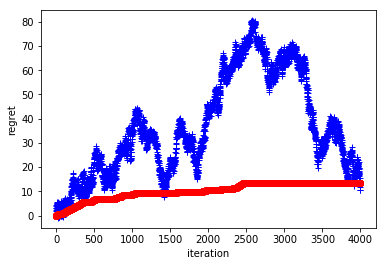

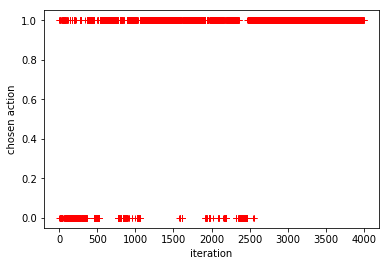

In [0]:
experiment_ucb(k=2, mu=[0.2, 0.22], delta=0.01, rounds=4000)


The smaller delta, the more 'curious'/'optimistic' and 'less decisive' is the algorithm. It takes the algorithm longer to find the best arm. Yet, when delta is set to high, the chance is there, that it decides for the less valuable arm, based on some unlucky rounds. The longer it takes the algorithm to 'decide' on one arm, the higher the regret, but also the error probability of eventually finding the best arm is less.

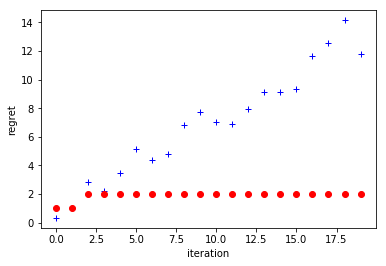

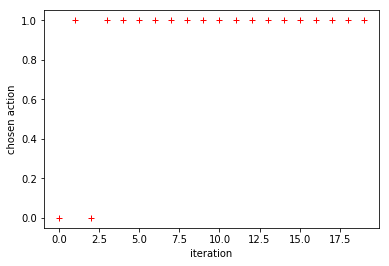

In [0]:
experiment_ucb(k=2, mu=[0, 1], delta=0.9, rounds=20)


For this run, the algorithm finds the best arm after the 3rd round.

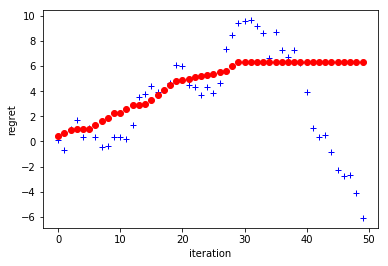

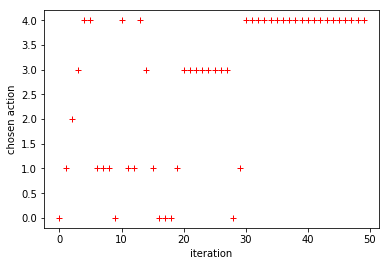

In [0]:
experiment_ucb(k=5, mu=[0, 0.1, 0.2, 0.3, 0.4], delta=0.2, rounds=50)

For this run, the algorithm finds the best arm after the 30th round.

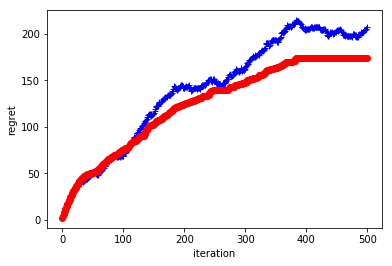

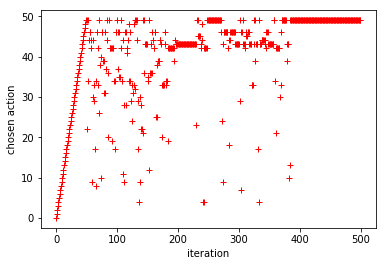

In [0]:
experiment_ucb(k=50, mu=np.linspace(0,2,50), delta=0.2, rounds=500)

With 50 arms, we nicely can see that in the beginning the decisions are quite optimistic and with time the algorithm gets more reluctant to play less valuable arms. After around 300 iterations, the algorithm converges to the best action for this run. (Note that I also counted the intitialization as "choosen action" to align the rewards with the actions. That causes the increasing line in the beginning.)